In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import numpy as np
import time
from model import MotionNet
import matplotlib.pyplot as plt
from data.data_utils import voxelize_occupy
from data.data_utils import voxelize_occupy_gpu, gen_non_empty_map_gpu
from utils import visualize_prediction
from pyquaternion import Quaternion
# import cupy as cp # For CUDA 10.2: pip install cupy-cuda102
# from collections import deque
from copy import deepcopy
# from functools import reduce
from plots import vis_scene_data

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.3 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Loaded pretrained model MotionNet
finish sample 0


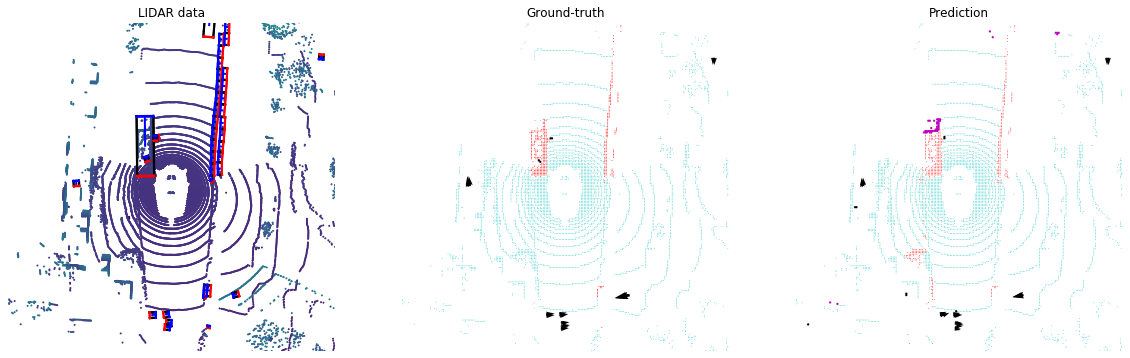

Finish loading sequence sample 1


In [2]:
vis_scene_data('/home/ruslan/datasets/nuscenes/',
               'v1.0-mini',
               trained_model_path='../weights/model.pth',
               img_save_dir='test',
               max_seq_num=1)

In [3]:
color_map = {0: 'c', 1: 'm', 2: 'k', 3: 'y', 4: 'r'}
cat_names = {0: 'bg', 1: 'vehicle', 2: 'ped', 3: 'bike', 4: 'other'}

def visualize_prediction(points, cat_pred, disp_pred):    
    # --- Visualization ---
    # Draw the LIDAR and quiver plots
    # The distant points are very sparse and not reliable. We do not show them.
    border_meter = 4
    border_pixel = border_meter * 4
    x_lim = [-(32 - border_meter), (32 - border_meter)]
    y_lim = [-(32 - border_meter), (32 - border_meter)]

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    ax[0].scatter(points[0, :], points[1, :], c=points[2, :], s=1)
    ax[0].set_xlim(x_lim[0], x_lim[1])
    ax[0].set_ylim(y_lim[0], y_lim[1])
    ax[0].axis('off')
    ax[0].set_aspect('equal')
    ax[0].title.set_text('LIDAR data')

    for k in range(len(color_map)):
        # ------------------------ Prediction ------------------------
        # Show the prediction results. We show the cells corresponding to the non-empty one-hot gt cells.
        mask_pred = cat_pred == (k + 1)
        field_pred = disp_pred[-1]  # Show last prediction, ie., the 20-th frame

        # For cells with very small movements, we threshold them to be static
        field_pred_norm = np.linalg.norm(field_pred, ord=2, axis=-1)  # out: (h, w)
        thd_mask = field_pred_norm <= 0.4
        field_pred[thd_mask, :] = 0

        # Plot quiver. We only show non-empty vectors. Plot each category.
        idx_x = np.arange(field_pred.shape[0])
        idx_y = np.arange(field_pred.shape[1])
        idx_x, idx_y = np.meshgrid(idx_x, idx_y, indexing='ij')
        qk = [None] * len(color_map)  # for quiver key

        # We use the same indices as the ground-truth, since we are currently focused on the foreground
        X_pred = idx_x[mask_pred]
        Y_pred = idx_y[mask_pred]
        U_pred = field_pred[:, :, 0][mask_pred] / voxel_size[0]
        V_pred = field_pred[:, :, 1][mask_pred] / voxel_size[1]

        ax[1].quiver(X_pred, Y_pred, U_pred, V_pred, angles='xy', scale_units='xy', scale=1, color=color_map[k])
        ax[1].set_xlim(border_pixel, field_pred.shape[0] - border_pixel)
        ax[1].set_ylim(border_pixel, field_pred.shape[1] - border_pixel)
        ax[1].set_aspect('equal')
        ax[1].title.set_text('Prediction')
        ax[1].axis('off')
    plt.show()

In [4]:
def gen_non_empty_map(refer_pc: np.array, grid_size: np.array, extents: np.array = None):
    """
    :param refer_pc: point cloud of shape (N, 3)
    :param grid_size: The size of each pixel
    :param extents: The extents of the point cloud on the 2D xy plane. Shape (3, 2)

    :return: Non empty map. Shape (image height, image width).
    """
    # ----------------------------------------------------
    # Filter and sort the reference point cloud
    refer_pc = refer_pc[:, 0:3]

    if extents is not None:
        if extents.shape != (3, 2):
            raise ValueError("Extents are the wrong shape {}".format(extents.shape))

        filter_idx = np.where((extents[0, 0] < refer_pc[:, 0]) & (refer_pc[:, 0] < extents[0, 1]) &
                              (extents[1, 0] < refer_pc[:, 1]) & (refer_pc[:, 1] < extents[1, 1]) &
                              (extents[2, 0] < refer_pc[:, 2]) & (refer_pc[:, 2] < extents[2, 1]))[0]
        refer_pc = refer_pc[filter_idx]

    # -- Discretize pixel coordinates to given quantization size
    discrete_pts = np.floor(refer_pc[:, 0:2] / grid_size).astype(np.int32)

    # -- Use Lex Sort, sort by x, then y
    x_col = discrete_pts[:, 0]
    y_col = discrete_pts[:, 1]
    sorted_order = np.lexsort((y_col, x_col))

    refer_pc = refer_pc[sorted_order]
    discrete_pts = discrete_pts[sorted_order]

    contiguous_array = np.ascontiguousarray(discrete_pts).view(
        np.dtype((np.void, discrete_pts.dtype.itemsize * discrete_pts.shape[1])))

    # -- The new coordinates are the discretized array with its unique indexes
    _, unique_indices = np.unique(contiguous_array, return_index=True)

    # -- Sort unique indices to preserve order
    unique_indices.sort()
    pixel_coords = discrete_pts[unique_indices]

    # -- Compute the minimum and maximum voxel coordinates
    if extents is not None:
        min_pixel_coord = np.floor(extents.T[0, 0:2] / grid_size)
        max_pixel_coord = np.ceil(extents.T[1, 0:2] / grid_size) - 1
    else:
        min_pixel_coord = np.amin(pixel_coords, axis=0)
        max_pixel_coord = np.amax(pixel_coords, axis=0)

    # -- Get the voxel grid dimensions
    num_divisions = ((max_pixel_coord - min_pixel_coord) + 1).astype(np.int32)

    # -- Bring the min voxel to the origin
    pixel_indices = (pixel_coords - min_pixel_coord).astype(int)
    # ----------------------------------------------------

    # ----------------------------------------------------
    # Set the non-zero pixels to 1.0
    # Note that the non-zero pixels correspond to the foreground and background objects
    non_empty_map = np.zeros((num_divisions[0], num_divisions[1]), dtype=np.float32)
    non_empty_map[pixel_indices[:, 0], pixel_indices[:, 1]] = 1.0

    return non_empty_map

In [5]:
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained network weights
model = MotionNet(out_seq_len=20, motion_category_num=2, height_feat_size=13)
model = nn.DataParallel(model)
checkpoint = torch.load('../weights/model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Prepare data for the network
nusc = NuScenes(version='v1.0-mini', dataroot='/home/ruslan/datasets/nuscenes/', verbose=True)

nsweeps_back = 20
nsweeps_forward = 20
num_frame_skipped = 0
which_scene = 1
frame_skip = 3

voxel_size = (0.25, 0.25, 0.4)
area_extents = np.array([[-32., 32.], [-32., 32.], [-3, 2]])

curr_scene = nusc.scene[which_scene]

first_sample_token = curr_scene['first_sample_token']
last_sample_token = curr_scene['last_sample_token']
curr_sample = nusc.get('sample', first_sample_token)
curr_sample_data = nusc.get('sample_data', curr_sample['data']['LIDAR_TOP'])

color_map = {0: 'c', 1: 'm', 2: 'k', 3: 'y', 4: 'r'}

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Example doesn't incorporate odometry for PCs synchronization. Input point clouds should be in the same coordinate system.
So the predictions are not accurate.

 95%|█████████▌| 19/20 [00:05<00:00,  2.08it/s]

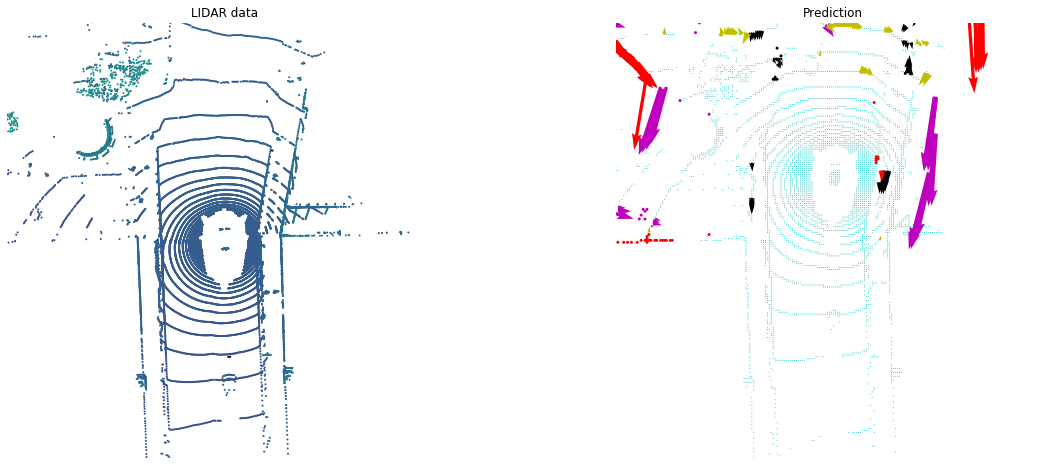

100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


In [6]:
for _ in tqdm( range(20) ):
    # Get the synchronized point clouds
    all_pc, all_times = LidarPointCloud.from_file_multisweep_bf_sample_data(nusc, curr_sample_data,
                                                                            nsweeps_back=nsweeps_back,
                                                                            nsweeps_forward=nsweeps_forward)

    # Store point cloud of each sweep
    pc = all_pc.points
    _, sort_idx = np.unique(all_times, return_index=True)
    unique_times = all_times[np.sort(sort_idx)]  # Preserve the item order in unique_times
    num_sweeps = len(unique_times)

    # Make sure we have sufficient past and future sweeps
    if num_sweeps != (nsweeps_back + nsweeps_forward):
        curr_sample_data = nusc.get('sample_data', curr_sample_data['next'])
        continue

    # --- Load the point cloud data and annotations ---
    num_past_sweeps = len(np.where(unique_times >= 0)[0])
    num_future_sweeps = len(np.where(unique_times < 0)[0])
    assert num_past_sweeps + num_future_sweeps == num_sweeps, "The number of sweeps is incorrect!"

    # Load point cloud
    pc_list = []

    for tid in range(num_sweeps):
        _time = unique_times[tid]
        points_idx = np.where(all_times == _time)[0]
        pc = all_pc.points[:, points_idx]
        pc_list.append(pc)

    # Reorder the pc, and skip sample frames if wanted
    tmp_pc_list_1 = pc_list[0:num_past_sweeps:(frame_skip + 1)]
    tmp_pc_list_1 = tmp_pc_list_1[::-1]
    tmp_pc_list_2 = pc_list[(num_past_sweeps + frame_skip)::(frame_skip + 1)]
    pc_list = tmp_pc_list_1 + tmp_pc_list_2

    num_past_pcs = len(tmp_pc_list_1)
    num_future_pcs = len(tmp_pc_list_2)

    # Voxelize the input point clouds, and compute the ground truth displacement vectors
    padded_voxel_points_list = list()  # This contains the compact representation of voxelization, as in the paper

    for i in range(num_past_pcs):
        res = voxelize_occupy(pc_list[i].T, voxel_size=voxel_size, extents=area_extents)
        padded_voxel_points_list.append(res)

    # Compile the batch of voxels, so that they can be fed into the network
    padded_voxel_points = torch.from_numpy(np.stack(padded_voxel_points_list, axis=0))
    padded_voxel_points = torch.unsqueeze(padded_voxel_points, 0).to(device)

    non_empty_map = gen_non_empty_map(pc_list[-1].T, voxel_size[0:2], area_extents)
    # Make prediction
    with torch.no_grad():
        disp_pred, cat_pred, motion_pred = model(padded_voxel_points)
        
        disp_pred = disp_pred.cpu().numpy()
        disp_pred = np.transpose(disp_pred, (0, 2, 3, 1))
        cat_pred = np.squeeze(cat_pred.cpu().numpy(), 0)

        for c in range(1, disp_pred.shape[0]):
            disp_pred[c, ...] = disp_pred[c, ...] + disp_pred[c - 1, ...]

        motion_pred_numpy = motion_pred.cpu().numpy()
        motion_pred_numpy = np.argmax(motion_pred_numpy, axis=1)
        motion_mask = motion_pred_numpy == 0

        cat_pred_numpy = np.argmax(cat_pred, axis=0)
        cat_mask = np.logical_and(cat_pred_numpy == 0, non_empty_map == 1)
        cat_mask = np.expand_dims(cat_mask, 0)
        cat_weight_map = np.ones_like(motion_pred_numpy, dtype=np.float32)
        cat_weight_map[motion_mask] = 0.0
        cat_weight_map[cat_mask] = 0.0
        cat_weight_map = cat_weight_map[:, :, :, np.newaxis]  # (1, h, w. 1)
        
        disp_pred = disp_pred * cat_weight_map

    # ------------------------- Visualization -------------------------
    # Draw the LIDAR and quiver plots
    # The distant points are very sparse and not reliable. We do not show them.
    border_meter = 4
    border_pixel = border_meter * 4
    x_lim = [-(32 - border_meter), (32 - border_meter)]
    y_lim = [-(32 - border_meter), (32 - border_meter)]

    cat_pred = np.argmax(cat_pred, axis=0) + 1
    # cat_pred = (cat_pred * non_empty_map * filter_mask).astype(np.int)
    cat_pred = (cat_pred * non_empty_map).astype(np.int)

    idx = num_past_pcs - 1
    points = pc_list[idx]
    
    visualize_prediction(points, cat_pred, disp_pred)
        
    curr_sample_data = nusc.get('sample_data', curr_sample_data['next'])